# Step 4 - Correlation Analysis

This notebook trains a network to mimic the Blackbox version, using all clients in the training set to perform the task. We use the test set to evaluate how close the Discriminator model is from the Blackbox version.

## Imports

In [1]:
import tensorflow as tf
tf.keras.backend.clear_session()  # For easy reset of notebook state.
from tensorflow import keras  # Import the tf version of keras.
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import keras.backend as K
from keras.datasets import mnist

print(tf.__version__)
print(keras.__version__)

1.15.0
2.2.4-tf


Using TensorFlow backend.


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import ticker
from tqdm import tqdm_notebook, tqdm
import pickle

import os.path
import shutil
import math
import random
import seaborn as sns

In [3]:
# Setting seeds for reproducibility 
np.random.seed(0)
tf.set_random_seed(0)

# Enlargen plots
plt.rcParams['figure.figsize'] = [10, 5]

## Parameters

In [4]:
# model params (MUST MATCH Blackbox Evaluator PARAMS)
num_classes = 10
max_epochs = 25
save_every = 1
discriminator_epochs = 25

# client params
clients_per_class = 100                         # number of clients per label. Each client only has access to one label
                                                # - each unique class is divided into X number of subsets
    
minibatch_size = None                           # number of samples to operate on at one time
                                                # - can vary to optimize computing requirements
                                                # - if None, will evaluate the client's whole batch regardless of its size
    
batches_per_train_step = 20                     # after averaging the gradients from X clients, we will apply them to the model

shuffle_clients = True

# dataset params
separated_folder = "./separated_dataset"
os.makedirs(separated_folder, exist_ok=True)
separated_train_path = os.path.join(separated_folder, "train_separated.pkl")
separated_test_path = os.path.join(separated_folder, "test_separated.pkl")

# input image dimensions
img_rows, img_cols = 28, 28
target_rows, target_cols = 28, 28    # governed by the chosen model

## Load Data

In [5]:
# The data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if target_rows != img_rows or target_cols != img_cols:
    # resize x_train
    x_train_resized = []
    for x_ in x_train:
        # scale image to be the same WxH as we need:
        x_ = cv2.resize(x_, dsize=(target_rows, target_cols), interpolation=cv2.INTER_CUBIC)
        x_train_resized.append(x_)
    x_train = np.asarray(x_train_resized)

    # resize x_test
    x_test_resized = []
    for x_ in x_test:
        # scale image to be the same WxH as we need:
        x_ = cv2.resize(x_, dsize=(target_rows, target_cols), interpolation=cv2.INTER_CUBIC)
        x_test_resized.append(x_)
    x_test = np.asarray(x_test_resized)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
# summary of data shapes:
print('X:', x_train.shape, x_test.shape)
print('y:', y_train.shape, y_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

X: (60000, 28, 28, 1) (10000, 28, 28, 1)
y: (60000, 10) (10000, 10)
60000 train samples
10000 test samples


#### Separate the data by class

In [7]:
# Separating the data by class
if os.path.isfile(separated_train_path):
    with open(separated_train_path, 'rb') as f:
        x_train_dict, y_train_dict = pickle.load(f)
        print('loaded training seperation')
else:
    x_train_dict = {}
    y_train_dict = {}
    for target_label in tqdm_notebook(range(10)):
        x_train_dict[target_label] = []
        y_train_dict[target_label] = []
        for i, label in enumerate(y_train):
            if list(label).index(1) == target_label:
                x_train_dict[target_label].append(x_train[i])
                y_train_dict[target_label].append(y_train[i])
    
    with open(separated_train_path, 'wb') as f:
        pickle.dump([x_train_dict, y_train_dict], f)
        print('saved training seperation')

if os.path.isfile(separated_test_path):
    with open(separated_test_path, 'rb') as f:
        x_test_dict, y_test_dict = pickle.load(f)
        print('loaded testing seperation')
else:
    x_test_dict = {}
    y_test_dict = {}
    for target_label in tqdm_notebook(range(10)):
        x_test_dict[target_label] = []
        y_test_dict[target_label] = []
        for i, label in enumerate(y_test):
            if list(label).index(1) == target_label:
                x_test_dict[target_label].append(x_test[i])
                y_test_dict[target_label].append(y_test[i])

    with open(separated_test_path, 'wb') as f:
        pickle.dump([x_test_dict, y_test_dict], f)
        print('saved testing seperation')
    
# convert dicts to lists
x_train_seperated = [np.array(x_train_dict[i]) for i in range(10)]
y_train_seperated = [np.array(y_train_dict[i]) for i in range(10)]

x_test_seperated = [np.array(x_test_dict[i]) for i in range(10)]
y_test_seperated = [np.array(y_test_dict[i]) for i in range(10)]

loaded training seperation
loaded testing seperation


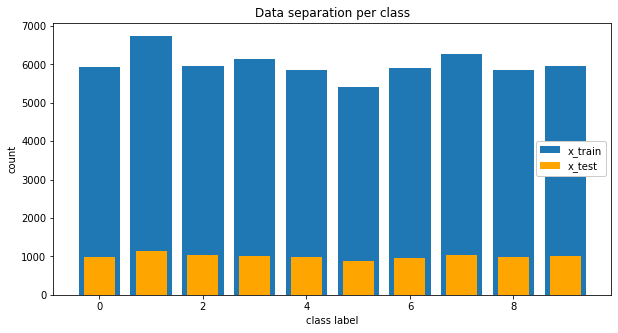

In [8]:
# summary of data shapes:
plt.figure()
plt.title('Data separation per class')
plt.bar(x_train_dict.keys(), [len(v) for v in x_train_dict.values()], color='tab:blue')
plt.bar(x_test_dict.keys(), [len(v) for v in x_test_dict.values()], color='orange', width=0.6)
plt.legend(['x_train', 'x_test'], loc='center right', framealpha=1.0)
plt.xlabel('class label')
plt.ylabel('count')
plt.show()

#### Separate the data into batches for clients to use

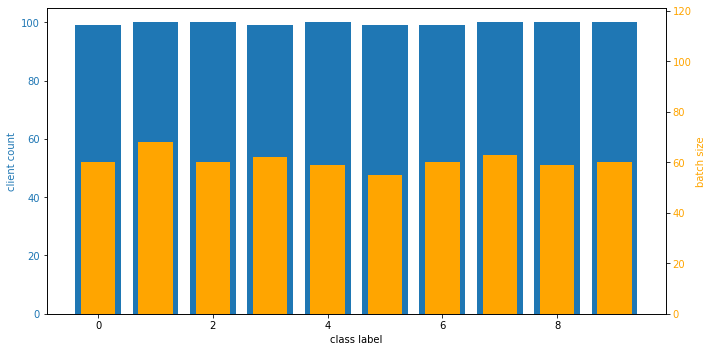

Clients per class:  99.6 ~= 100
Total number of clients: 996
Average batch size: 60.6


In [9]:
# Separate the data into a long list of batches, each batch representing a client training with that batch of images.
# After each batch, a new client will have the opportunity to train their batch of images.
# Batches are shuffled to simulate many clients training the model at once.

client_counts = {}
batch_sizes = {}
x_batches = []
y_batches = []

def ceil(a,b):
    return -(-a//b)

for class_idx in range(len(x_train_seperated)):
    # Get batches from class data:
    n_samples_per_class = len(x_train_seperated[class_idx])
    samples_per_client = n_samples_per_class / clients_per_class
    better_batch_size = int(math.ceil(samples_per_client))

    count = 0
    for i in range(ceil(n_samples_per_class, better_batch_size)):
        x_batches.append((class_idx, x_train_seperated[class_idx][i * better_batch_size: (i+1) * better_batch_size]))
        y_batches.append((class_idx, y_train_seperated[class_idx][i * better_batch_size: (i+1) * better_batch_size]))
        count += 1
    client_counts[class_idx] = count
    batch_sizes[class_idx] = better_batch_size
        
# double check that the clients_per_class is upheld per class
# (blue bars should be uniform, orange should change according to class):
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('class label')
ax1.set_ylabel('client count', color=color)
plt.bar(client_counts.keys(), [v for v in client_counts.values()], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'orange'
ax2.set_ylabel('batch size', color=color)  # we already handled the x-label with ax1
plt.bar(batch_sizes.keys(), [v for v in batch_sizes.values()], color=color, width=0.6)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, np.mean([v for v in batch_sizes.values()])*2)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

print('Clients per class:  {} ~= {}'.format(np.mean([v for v in client_counts.values()]), clients_per_class))
print('Total number of clients: {}'.format(np.sum([v for v in client_counts.values()])))
print('Average batch size: {}'.format(np.mean([v for v in batch_sizes.values()])))

#### Load the y_eval sets generated by the Blackbox model

## Build Model

In [10]:
def blackbox_model(input_layer, depth=1, filters=4, dense_breadth=128, training=True):
    assert depth >= 1
    assert filters >= 1
    assert dense_breadth >= num_classes
    
    h = Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape)(input_layer)
    for i in range(depth-1):
        h = Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same')(h)
    h = MaxPooling2D(pool_size=(2, 2))(h)
    h = Dropout(0.25)(h, training=training)
    h = Flatten()(h)
    h = Dense(dense_breadth, activation='relu')(h)
    h = Dropout(0.5)(h, training=training)
    output_layer = Dense(num_classes, activation='softmax')(h)
    
    return output_layer

In [11]:
# to remove model complexity, the blackbox and discriminator models will be kept the same

def discriminator_model(input_layer, depth=1, filters=4, dense_breadth=128, training=True):
    model = blackbox_model(input_layer, depth, filters, dense_breadth, training)
    
    return model

In [12]:
input_shape = (target_rows, target_cols, 1)

## Graph Creation

In [13]:
class DiscriminatorModel:
    
    def __init__(self, input_shape, depth, filters, dense, training=True):
        self.input_shape = input_shape
        self.training = training
        self.depth = depth
        self.filters = filters
        self.dense = dense
        
        self.accumulate_ops = None
        self.train_step = None
        self.zero_ops = None
        
        self.create_graph()
        self.create_optimizer()
        self.split_learning_ops()
        
    def create_graph(self):
        # add place for input and pred label
        self.x = keras.Input(shape=self.input_shape)
        self.y_discriminator = discriminator_model(self.x, self.depth, self.filters, self.dense, training=self.training)
        
        # add node for input from evaluated model
        self.y_blackbox = keras.Input(shape=(num_classes, ))

        # add place for truth label
        self.y_true = keras.Input(shape=(num_classes, ))
        
    def create_optimizer(self):
        # Define loss function in terms of y_pred and y_true
        self.loss = keras.losses.MSE(self.y_blackbox, self.y_discriminator)

        # Setup metrics to look at during training:
        _, self.acc_op_b = tf.metrics.accuracy(labels=tf.argmax(self.y_true, 1), predictions=tf.argmax(self.y_blackbox,1))
        _, self.acc_op_d = tf.metrics.accuracy(labels=tf.argmax(self.y_true, 1), predictions=tf.argmax(self.y_discriminator,1))

        # Define extra accuracy to look at acc between both models
        _, self.acc_op_c = tf.metrics.accuracy(labels=tf.argmax(self.y_blackbox, 1), predictions=tf.argmax(self.y_discriminator, 1))
    
        ## Optimizer definition - nothing different from any classical example
        self.optimizer = tf.train.AdamOptimizer()

        # Add ops to save and restore all the variables.
        self.saver = tf.train.Saver(max_to_keep=discriminator_epochs)
        
    def split_learning_ops(self):
        # INSPIRED by https://stackoverflow.com/questions/42156957/how-to-update-model-parameters-with-accumulated-gradients

        # Fetch a list of our network's trainable parameters.
        self.trainable_vars = tf.trainable_variables()

        # Create variables to store accumulated gradients
        self.accumulators = [
            tf.Variable(
                tf.zeros_like(tv.initialized_value()),
                trainable=False
            ) for tv in self.trainable_vars
        ]

        # Create a variable for counting the number of accumulations
        self.accumulation_counter = tf.Variable(0.0, trainable=False)

        # Compute gradients; grad_pairs contains (gradient, variable) pairs
        self.grad_pairs = self.optimizer.compute_gradients(self.loss, self.trainable_vars)

        # Create operations which add a variable's gradient to its accumulator.
        self.accumulate_ops = [
            accumulator.assign_add(
                grad
            ) for (accumulator, (grad, var)) in zip(self.accumulators, self.grad_pairs)
        ]

        # The final accumulation operation is to increment the counter
        self.accumulate_ops.append(self.accumulation_counter.assign_add(1.0))

        # Update trainable variables by applying the accumulated gradients
        # divided by the counter. Note: apply_gradients takes in a list of 
        # (grad, var) pairs
        self.train_step = self.optimizer.apply_gradients(
            [(accumulator / self.accumulation_counter, var) \
                for (accumulator, (grad, var)) in zip(self.accumulators, self.grad_pairs)]
        )

        # Accumulators must be zeroed once the accumulated gradient is applied.
        self.zero_ops = [
            accumulator.assign(
                tf.zeros_like(tv)
            ) for (accumulator, tv) in zip(self.accumulators, self.trainable_vars)
        ]

        # Add one last op for zeroing the counter
        self.zero_ops.append(self.accumulation_counter.assign(0.0))
        
    def count_params(self):
        # create a model representation
        model_ = keras.Model(inputs=self.x, outputs=self.y_discriminator)
        
        # return the number of parameters
        return model_.count_params()

## Split Training

In [14]:
# List of the different configurations we will step through
# ETA: 75 mins * 18 = 22.5 hours

configs_depth = list(range(1, 11, 4))
configs_filters = list(range(1, 81, 32))
configs_dense = list(range(10, 200, 100))
total_combinations = len(configs_depth) * len(configs_filters) * len(configs_dense)

print('{} total combinations of networks'.format(total_combinations))
print('depths:', configs_depth)
print('filters:', configs_filters)
print('denses:', configs_dense)

18 total combinations of networks
depths: [1, 5, 9]
filters: [1, 33, 65]
denses: [10, 110]


In [15]:
eval_folder = "./comparison_evals"
if os.path.exists(eval_folder):
    print('Loading the evaluation results for comparison.')
    
    eval_file = os.path.join(eval_folder, 'accs_test_b.pkl')
    with open(eval_file, 'rb') as f:
        accs_test_b = pickle.load(f)

    eval_file = os.path.join(eval_folder, 'accs_test_d.pkl')
    with open(eval_file, 'rb') as f:
        accs_test_d = pickle.load(f)

    eval_file = os.path.join(eval_folder, 'accs_test_c.pkl')
    with open(eval_file, 'rb') as f:
        accs_test_c = pickle.load(f)

    eval_file = os.path.join(eval_folder, 'losses_test.pkl')
    with open(eval_file, 'rb') as f:
        losses_test = pickle.load(f)

    eval_file = os.path.join(eval_folder, 'param_counts.pkl')
    with open(eval_file, 'rb') as f:
        param_counts = pickle.load(f)
else:
    print('Evaluating the Discriminator models...\n')
    os.makedirs(eval_folder, exist_ok=False)

    accs_test_b = {}
    accs_test_d = {}
    losses_test = {}
    accs_test_c = {}
    param_counts = {}

    pbar = tqdm_notebook(total=total_combinations*total_combinations)

    for depth_b in configs_depth:
        for filters_b in configs_filters:
            for dense_b in configs_dense:

                #######################################################################################

                # Load the outputs from the blackbox
                filename_b = 'blackbox_e{}_d{}_f{}_d{}'.format(max_epochs, depth_b, filters_b, dense_b)
                filename_b_short = 'b_e{}_d{}_f{}_d{}'.format(max_epochs, depth_b, filters_b, dense_b)

                # Create the dict objects
                accs_test_b[filename_b] = {}
                accs_test_d[filename_b] = {}
                losses_test[filename_b] = {}
                accs_test_c[filename_b] = {}

                # load the pickle files:
                eval_folder = "./blackbox_evals/{}".format(filename_b)

                # load training batches
                batch_idxs = list(range(len(x_batches)))
                blackbox_train_batches = []
                for batch_idx in batch_idxs:
                    eval_file = os.path.join(eval_folder, 'train_{}.pkl'.format(batch_idx))
                    with open(eval_file, 'rb') as f:
                        y_eval = pickle.load(f)
                    blackbox_train_batches.append(y_eval)

                # load testing batches
                eval_file = os.path.join(eval_folder, 'test_all.pkl')
                with open(eval_file, 'rb') as f:
                    y_eval = pickle.load(f)
                b_test = y_eval

                # load the param count
                param_file = os.path.join(eval_folder, 'param_count.pkl')
                with open(param_file, 'rb') as f:
                    param_count_b = pickle.load(f)

                param_counts[filename_b] = param_count_b

                #######################################################################################

                # Load the discriminator weights

                for depth_d in configs_depth:
                    for filters_d in configs_filters:
                        for dense_d in configs_dense:

                            filename_d = 'discriminator_e{}_d{}_f{}_d{}'.format(discriminator_epochs, depth_d, filters_d, dense_d)
                            filename_d_short = 'd_e{}_d{}_f{}_d{}'.format(discriminator_epochs, depth_d, filters_d, dense_d)
                            pbar.set_description(filename_d)

                            # train a new model each time:
                            model_obj = DiscriminatorModel(input_shape, depth_d, filters_d, dense_d, training=False)

                            with tf.Session() as sess:
                                # init the session:
                                sess.run(tf.local_variables_initializer())
                                sess.run(tf.global_variables_initializer())

                                # Load the discriminator weights:
                                checkpoint_folder = "./discriminator_checkpoints/{}/{}".format(filename_b_short, filename_d_short)
                                discriminator_weights_path = os.path.join(checkpoint_folder, 'discriminator_checkpoint.ckpt')
                                # model.load_weights(blackbox_weights_path)
                                model_obj.saver.restore(sess, discriminator_weights_path)

                                # Evaluate the discriminator

                                # Calculate test acc and loss
                                acc_test_b, acc_test_d, loss_test, acc_test_c = sess.run([
                                    model_obj.acc_op_b, model_obj.acc_op_d, model_obj.loss, model_obj.acc_op_c],
                                    feed_dict={model_obj.x: x_test, model_obj.y_blackbox: b_test, 
                                               model_obj.y_true: y_test})
                                loss_test = np.sum(loss_test)

                                accs_test_b[filename_b][filename_d] = acc_test_b
                                accs_test_d[filename_b][filename_d] = acc_test_d
                                losses_test[filename_b][filename_d] = loss_test
                                accs_test_c[filename_b][filename_d] = acc_test_c
                                param_counts[filename_d] = model_obj.count_params()

                                pbar.update(1)

                            # Flush out the session
                            keras.backend.clear_session()
    pbar.close()
    
    # save the evaluated metrics

    eval_file = os.path.join(eval_folder, 'accs_test_b.pkl')
    with open(eval_file, 'wb') as f:
        pickle.dump(accs_test_b, f)

    eval_file = os.path.join(eval_folder, 'accs_test_d.pkl')
    with open(eval_file, 'wb') as f:
        pickle.dump(accs_test_d, f)

    eval_file = os.path.join(eval_folder, 'accs_test_c.pkl')
    with open(eval_file, 'wb') as f:
        pickle.dump(accs_test_c, f)

    eval_file = os.path.join(eval_folder, 'losses_test.pkl')
    with open(eval_file, 'wb') as f:
        pickle.dump(losses_test, f)

    eval_file = os.path.join(eval_folder, 'param_counts.pkl')
    with open(eval_file, 'wb') as f:
        pickle.dump(param_counts, f)

Loading the evaluation results for comparison.


In [16]:
# separate dara into x and y 1d arrays

order = np.zeros((total_combinations, )) # keep track of order
b_param = np.zeros((total_combinations, total_combinations))
d_param = np.zeros((total_combinations, total_combinations))

acc_b = np.zeros((total_combinations, total_combinations))
acc_d = np.zeros((total_combinations, total_combinations))
acc_c = np.zeros((total_combinations, total_combinations))
loss = np.zeros((total_combinations, total_combinations))

b_param_accum = np.zeros((total_combinations * total_combinations, ))
d_param_accum = np.zeros((total_combinations * total_combinations, ))
acc_b_accum = np.zeros((total_combinations * total_combinations, ))
acc_d_accum = np.zeros((total_combinations * total_combinations, ))
acc_c_accum = np.zeros((total_combinations * total_combinations, ))
loss_accum = np.zeros((total_combinations * total_combinations, ))

network_description = np.zeros((total_combinations * total_combinations, 7))

b = 0
for depth_b in configs_depth:
    for filters_b in configs_filters:
        for dense_b in configs_dense:
            
            d = 0
            for depth_d in configs_depth:
                for filters_d in configs_filters:
                    for dense_d in configs_dense:
                        
                        filename_b = 'blackbox_e{}_d{}_f{}_d{}'.format(max_epochs, depth_b, filters_b, dense_b)
                        filename_d = 'discriminator_e{}_d{}_f{}_d{}'.format(discriminator_epochs, depth_d, filters_d, dense_d)
                        
                        order[d] = param_counts[filename_d]
                        
                        b_param[b][d] = param_counts[filename_b]
                        d_param[b][d] = param_counts[filename_d]
                        
                        acc_b[b][d] = accs_test_b[filename_b][filename_d]
                        acc_d[b][d] = accs_test_d[filename_b][filename_d]
                        acc_c[b][d] = accs_test_c[filename_b][filename_d]
                        loss[b][d] = losses_test[filename_b][filename_d]
                        
                        b_param_accum[b*total_combinations + d] = param_counts[filename_b]
                        d_param_accum[b*total_combinations + d] = param_counts[filename_d]
                        
                        acc_b_accum[b*total_combinations + d] = accs_test_b[filename_b][filename_d]
                        acc_d_accum[b*total_combinations + d] = accs_test_d[filename_b][filename_d]
                        acc_c_accum[b*total_combinations + d] = accs_test_c[filename_b][filename_d]
                        loss_accum[b*total_combinations + d] = losses_test[filename_b][filename_d]
                        
                        network_description[b*total_combinations + d] = [depth_b, filters_b, 
                                                                         dense_b, depth_d, filters_d, 
                                                                         dense_d, acc_c_accum[b*total_combinations + d]]
                        
                        d += 1
            b += 1

#### Contour analysis of Discriminator wrt BB accuracy

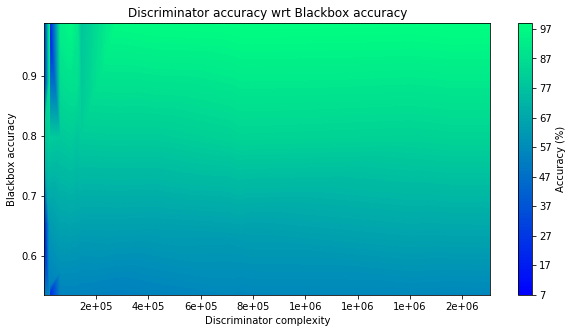

In [17]:
# ----------
# Tricontour
# ----------
# Directly supply the unordered, irregularly spaced coordinates
# to tricontour.

fig = plt.figure()
ax = plt.gca()

cntr = ax.tricontourf(d_param_accum, acc_b_accum, acc_c_accum*100, levels=100, cmap="winter")

cbar = fig.colorbar(cntr)
# ax.plot(d_param_accum, acc_b_accum, 'bo', ms=0.5)

cbar.set_label('Accuracy (%)')
plt.title('Discriminator accuracy wrt Blackbox accuracy')
plt.xlabel('Discriminator complexity')
plt.ylabel('Blackbox accuracy')

ax.get_xaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), '.0e')))

plt.show()

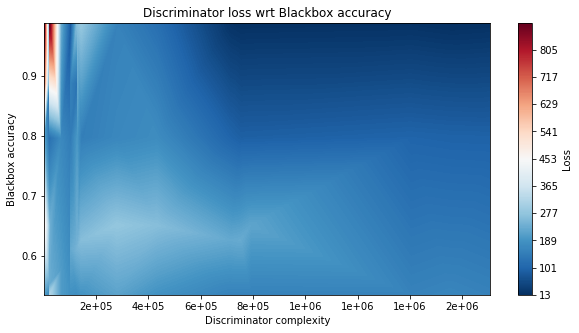

In [18]:
# ----------
# Tricontour
# ----------
# Directly supply the unordered, irregularly spaced coordinates
# to tricontour.

fig = plt.figure()
ax = plt.gca()

cntr = ax.tricontourf(d_param_accum, acc_b_accum, loss_accum, levels=1000, cmap="RdBu_r")

cbar = fig.colorbar(cntr)
# ax.plot(d_param_accum, acc_b_accum, 'wo', ms=0.5)

cbar.set_label('Loss')
plt.title('Discriminator loss wrt Blackbox accuracy')
plt.xlabel('Discriminator complexity')
plt.ylabel('Blackbox accuracy')

ax.get_xaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), '.0e')))

plt.show()

In [19]:
# plt.figure()
# plt.scatter(d_param_accum, b_param_accum, c=loss_accum, cmap='RdBu_r')
# cbar = plt.colorbar()
# cbar.set_label('Loss')
# plt.title('Discriminator loss wrt Blackbox complexity')
# plt.xlabel('Discriminator complexity')
# plt.ylabel('Blackbox complexity')
# plt.show()

##### 3D plot of Discriminator accuracy wrt BB accuracy

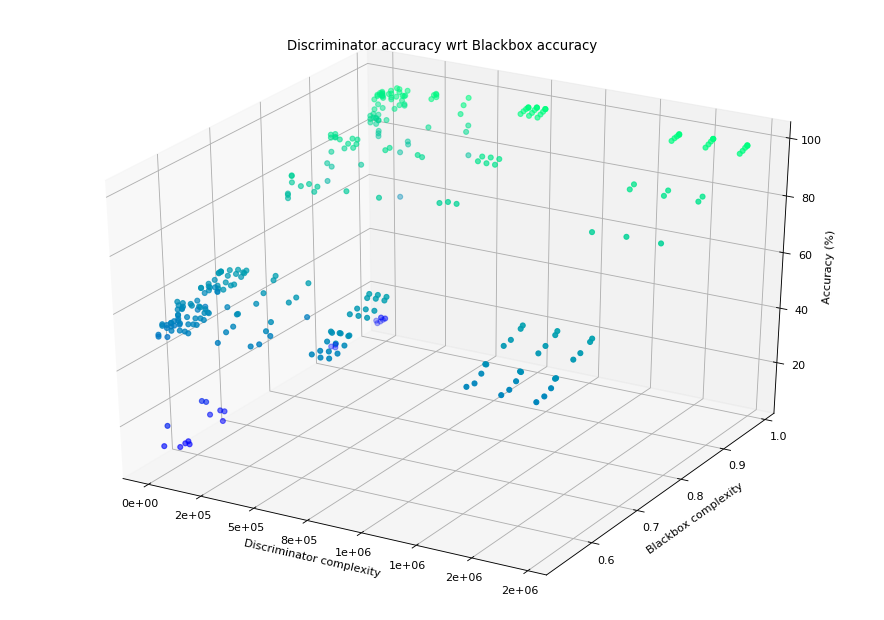

In [20]:
# %matplotlib qt
from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import has side effects, it enables using projection='3d' in add_subplot

fig = plt.figure(figsize=(14, 10), dpi=80)
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(d_param_accum, acc_b_accum, acc_c_accum*100, c=acc_c_accum, cmap='winter')

ax.get_xaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), '.0e')))
# ax.get_yaxis().set_major_formatter(
#     ticker.FuncFormatter(lambda x, p: format(int(x), '.0e')))

plt.title('Discriminator accuracy wrt Blackbox accuracy')
ax.set_xlabel('Discriminator complexity')
ax.set_ylabel('Blackbox complexity')
ax.set_zlabel('Accuracy (%)')

plt.show()

#### Contour analysis of Discriminator wrt BB complexity

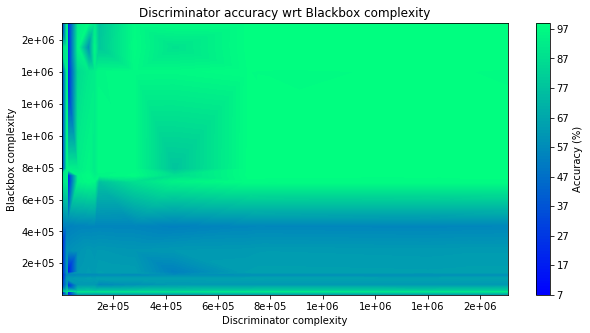

In [21]:
# ----------
# Tricontour
# ----------
# Directly supply the unordered, irregularly spaced coordinates
# to tricontour.

fig = plt.figure()
ax = plt.gca()

cntr = ax.tricontourf(d_param_accum, b_param_accum, acc_c_accum*100, levels=100, cmap="winter")

cbar = fig.colorbar(cntr)
# ax.plot(d_param_accum, b_param_accum, 'bo', ms=0.5)

cbar.set_label('Accuracy (%)')
plt.title('Discriminator accuracy wrt Blackbox complexity')
plt.xlabel('Discriminator complexity')
plt.ylabel('Blackbox complexity')

ax.get_xaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), '.0e')))
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), '.0e')))

plt.show()

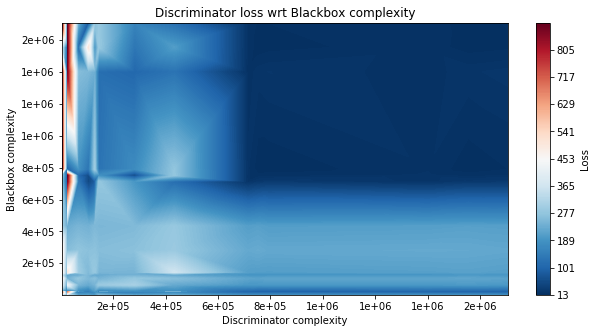

In [22]:
# ----------
# Tricontour
# ----------
# Directly supply the unordered, irregularly spaced coordinates
# to tricontour.

fig = plt.figure()
ax = plt.gca()

cntr = ax.tricontourf(d_param_accum, b_param_accum, loss_accum, levels=1000, cmap="RdBu_r")

cbar = fig.colorbar(cntr)
# ax.plot(d_param_accum, b_param_accum, 'wo', ms=0.5)

cbar.set_label('Loss')
plt.title('Discriminator loss wrt Blackbox complexity')
plt.xlabel('Discriminator complexity')
plt.ylabel('Blackbox complexity')

ax.get_xaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), '.0e')))
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), '.0e')))

plt.show()

In [23]:
# plt.figure()
# plt.scatter(d_param_accum, b_param_accum, c=acc_c_accum*100, cmap='winter')
# cbar = plt.colorbar()
# cbar.set_label('Accuracy (%)')
# plt.title('Discriminator accuracy wrt Blackbox complexity')
# plt.xlabel('Discriminator complexity')
# plt.ylabel('Blackbox complexity')
# plt.show()

##### 3D plot of Discriminator accuracy wrt BB complexity

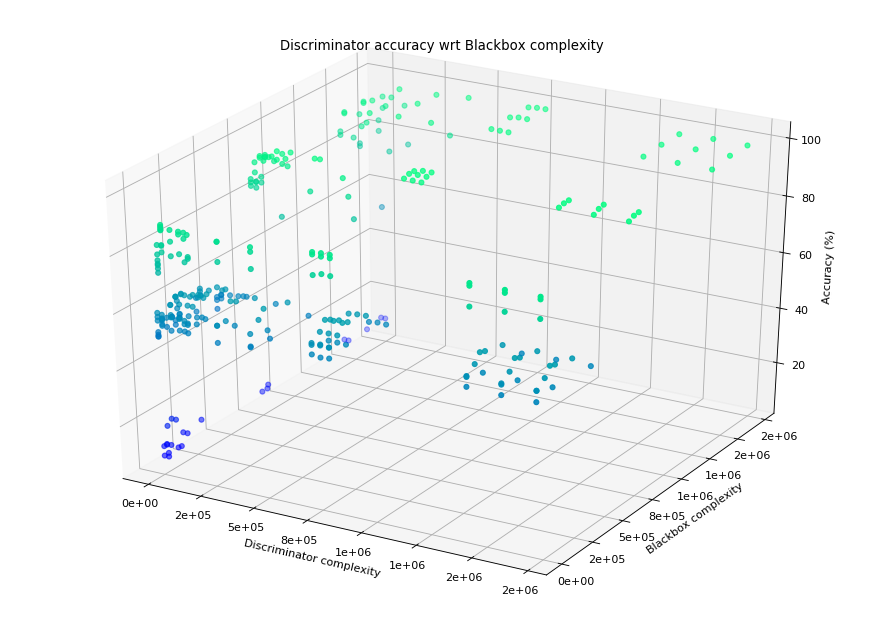

In [24]:
# %matplotlib qt
from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import has side effects, it enables using projection='3d' in add_subplot

fig = plt.figure(figsize=(14, 10), dpi=80)
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(d_param_accum, b_param_accum, acc_c_accum*100, c=acc_c_accum, cmap='winter')

ax.get_xaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), '.0e')))
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), '.0e')))

plt.title('Discriminator accuracy wrt Blackbox complexity')
ax.set_xlabel('Discriminator complexity')
ax.set_ylabel('Blackbox complexity')
ax.set_zlabel('Accuracy (%)')

plt.show()

#### Heatmap analysis

In [25]:
# # sort z_c by order of complexity:

# # sort i_c
# sorted_inds = np.argsort(order)

# # sort acc rows and columns
# acc_c_sorted = acc_c[sorted_inds][sorted_inds]

In [26]:
# sns.heatmap(acc_c.T, linewidth=0.5)

In [27]:
# sns.heatmap(acc_c_sorted.T, linewidth=0.5)

#### PCA analysis

In [28]:
# from sklearn.decomposition import PCA
# import pandas as pd

# pca = PCA()
# descr_pca = pca.fit_transform(network_description)
# descr_pca = pd.DataFrame(descr_pca)
# # descr_pca.head()

# print(pca.explained_variance_ratio_)

# descr_pca['target']=acc_c_accum
# descr_pca.columns = ['PC1','PC2','PC3','PC4', 'PC5', 'PC6', 'PC7', 'target']
# # descr_pca.head()

# plt.figure()
# plt.scatter(descr_pca['PC1'], descr_pca['PC2'], c=acc_c_accum*100, cmap='winter')
# cbar = plt.colorbar()
# cbar.set_label('Accuracy (%)')
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.show()

#### T-SNE analysis

In [29]:
# from sklearn.manifold import TSNE
# X_embedded = TSNE(n_components=2).fit_transform(network_description)

# plt.figure()
# plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=acc_c_accum*100, cmap='winter')
# cbar = plt.colorbar()
# cbar.set_label('Accuracy (%)')
# plt.show()

#### LR analysis
Predict the complexity of the model (filters, depth, etc) given the accuracy we get from Discriminator and the params we used in the Discriminator

In [30]:
# TODO